In [1]:
import findspark
import streamlit
findspark.init()

In [2]:
import pyspark

from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
df = spark.sql("select 'spark' as hello")
df.show()

/usr/local/lib/python3.12/site-packages/pyspark/bin/load-spark-env.sh: line 68: ps: command not found
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/11/15 09:16:16 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


+-----+
|hello|
+-----+
|spark|
+-----+



## Loading Data

In [3]:
df = spark.read.csv("brokendataset_large.csv", header=True, inferSchema=True)

df.printSchema()

root
 |-- gender: string (nullable = true)
 |-- race/ethnicity: string (nullable = true)
 |-- parental level of education: string (nullable = true)
 |-- lunch: string (nullable = true)
 |-- test preparation course: string (nullable = true)
 |-- math score: decimal(20,0) (nullable = true)
 |-- reading score: decimal(24,0) (nullable = true)
 |-- writing score: decimal(24,0) (nullable = true)



In [8]:
df2 = df.sample(0.01)
df2.show()

+-----------+--------------+---------------------------+------------+-----------------------+----------+-------------+-------------+
|     gender|race/ethnicity|parental level of education|       lunch|test preparation course|math score|reading score|writing score|
+-----------+--------------+---------------------------+------------+-----------------------+----------+-------------+-------------+
|     female|       group D|         associate's degree|    standard|               complete|        46|           46|           67|
|     female|       group C|                    college|free/reduced|               complete|        91|           72|           74|
|     female|       group C|          bachelor's degree|free/reduced|           not complete|        65|           31|           61|
|     female|       group A|                high school|    standard|               complete|        58|           57|           38|
|     Female|       group D|          bachelor's degree|    standard|

#### How many records?

In [10]:
num_records = df.count()
num_records

10000

In [11]:
df.where(df.gender == "female").count()

4294

count the number of records where the "math score" is above 80 and the "test preparation course" is "completed"

In [13]:
df.where((df['math score'] > 80) & (df['test preparation course'] == 'complete')).count()

1422

In [15]:
for col in df.columns:
    df3 = df.groupBy(col).count()
    df3.show()

+-----------+-----+
|     gender|count|
+-----------+-----+
|Undisclosed|   11|
|       NULL|  211|
|     Female|  100|
|     female| 4294|
|      other|  526|
|      Other|    6|
|       male| 4288|
|undisclosed|  482|
|       Male|   82|
+-----------+-----+

+--------------+-----+
|race/ethnicity|count|
+--------------+-----+
|       group B| 1929|
|       group C| 1920|
|       group D| 1926|
|          NULL|  190|
|       Group A|   43|
|       Group E|   35|
|       group A| 1907|
|       Group D|   39|
|       group E| 1934|
|       Group B|   41|
|       Group C|   36|
+--------------+-----+

+---------------------------+-----+
|parental level of education|count|
+---------------------------+-----+
|                    college| 2914|
|          Bachelor's degree|   28|
|                       NULL|  215|
|         associate's degree| 1914|
|            Master's degree|    5|
|                high school| 2878|
|                High school|   52|
|          bachelor's degree| 143

- Missing Completely as random **MCAR**
- Missing at random **MAR**
- Missing not at random **MNAR**

In [16]:
df2 = df.dropna(how = "any")
df2.show()

+-----------+--------------+---------------------------+------------+-----------------------+----------+-------------+-------------+
|     gender|race/ethnicity|parental level of education|       lunch|test preparation course|math score|reading score|writing score|
+-----------+--------------+---------------------------+------------+-----------------------+----------+-------------+-------------+
|     female|       group A|         associate's degree|    standard|               complete|        52|           32|           64|
|     female|       group A|                high school|Free/reduced|           not complete|        70|           55|           50|
|       male|       group A|                    college|    standard|               complete|        39|           50|           54|
|     female|       group B|                    college|free/reduced|               complete|        66|           71|           32|
|       male|       group B|         associate's degree|    standard|

In [17]:
df2.count()

9036

In [19]:
df2.groupBy("gender").count().show()

+-----------+-----+
|     gender|count|
+-----------+-----+
|Undisclosed|    9|
|     Female|   90|
|     female| 3949|
|      other|  485|
|      Other|    6|
|       male| 3987|
|undisclosed|  436|
|       Male|   74|
+-----------+-----+



Duplicate Categories

In [29]:
gender_map_dict = {
    "Female" : 'female',
    "Male": 'male',
    "Other": 'other',
    "Undisclosed": "undisclosed"
}

# race/ethnicity
race_map = {
    "group A" : "Group A",
    "group B" : "Group B",
    "group C" : "Group C",
    "group D" : "Group D",
    "group E" : "Group E",
}

education = {
    "college" : "College",
    "bachelor's degree": "Bachelor's degree",
    "associate's degree": "Associate's degree",
    "master's degree": "Master's degree",
    "high school": "High school"
}


lunch = {
    "free/reduced" : "Free/Reduced",
    "Free/reduced" : "Free/Reduced",
    "standard"     : "Standard"
}

course_prep = {
    "complete" : "Complete",
    "not complete" : "Not Complete",
    "Not complete" : "Not Complete"
}


df2 = df2.replace(to_replace=gender_map_dict, subset= ["gender"])
df2 = df2.replace(to_replace=race_map, subset=["race/ethnicity"])
df2 = df2.replace(to_replace=education, subset=["parental level of education"])
df2 = df2.replace(to_replace=lunch, subset=["lunch"])
df2 = df2.replace(to_replace=course_prep, subset=["test preparation course"])

df2.groupBy("test preparation course").count().show()

+-----------------------+-----+
|test preparation course|count|
+-----------------------+-----+
|           Not Complete| 4524|
|               Complete| 4512|
+-----------------------+-----+



## Duplicates

In [33]:
df4 = df2.dropDuplicates(
    [
     "gender",
     "race/ethnicity",
     "parental level of education",
     "lunch",
     "test preparation course",
     "math score",
     "reading score",
     "writing score"
    ]
)
df4.count()

8862

## Numerical Data

In [36]:
import matplotlib.pyplot as plt

df4.agg({"math score": "min"}).show()
df4.agg({"math score": "max"}).show()


+---------------+
|min(math score)|
+---------------+
|             30|
+---------------+

+--------------------+
|     max(math score)|
+--------------------+
|66666666666666666666|
+--------------------+



In [39]:
df4 = df4.filter(df4["math score"] < 2000)
df4.agg({"math score": "max"}).show()
df4.count()

+---------------+
|max(math score)|
+---------------+
|           1188|
+---------------+



8859

In [40]:
min = df4.agg({"math score": "min"})
min = min.first().asDict()["min(math score)"]

max = df4.agg({"math score": "max"})
max = max.first().asDict()["max(math score)"]

min = int(min)
max = int(max)

In [ ]:
math_score = df4.select("math score").collect()
math_scores = [int(i.asDict()['math score']) for i in math_score]
plt.boxplot(math_scores)
plt.show()

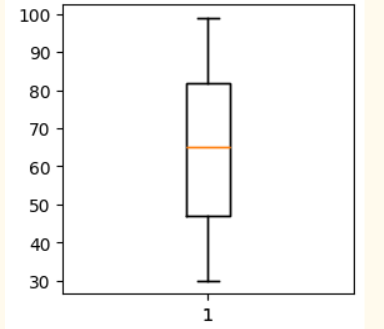

- Yellow (middle) line: median. This is 65 in our example.
- Box: extends from the lower to upper quartile. (From 47 to 82)
- Whiskers: indicate range.
    - Max whisker length: $Q1-(1.5*IQR)$ to $Q3+(1.5*IQR)$
    - Lower whisker: $47-(1.5 \times 35)=-5.5$ As the lowest data point is 30, the whisker stops at 30.
    - Upper whisker: $82+(1.5 \times 35)=134$ The whisker will stop at the highest data point that is less than 134.
    
Anything beyond the upper or lower whisker should be considered an outlier.